In [325]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [326]:
train = pd.read_csv('../input/train.csv', index_col='Id')
test = pd.read_csv('../input/test.csv', index_col='Id')

In [327]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

In [328]:
# constants
SKEW = 0.75

In [329]:
from scipy.stats import skew
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

train["SalePrice"] = np.log1p(train["SalePrice"])

In [330]:
# new feature: Valid Area
flrArea = all_data['1stFlrSF'] + all_data['2ndFlrSF']
validArea = flrArea + 0.7 * all_data.TotalBsmtSF + all_data.GarageArea
all_data['validArea'] = validArea

In [331]:
object_feats = all_data.dtypes[all_data.dtypes == object].index
all_data[object_feats] = all_data[object_feats].fillna('NA')

In [332]:
# new feature: quality / condition score
qc = ['ExterQual', 'BsmtQual', 'KitchenQual', 
        'GarageQual', 'ExterCond', 'BsmtCond', 'GarageCond','HeatingQC','FireplaceQu', 'PoolQC'
       ]

bsmt_exp_dict = {'Gd' : 4, 'Av' : 3, 'Mn' : 2, 'No' : 1, 'NA' : 0}
bsmt_fin_dict = {'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0}
garage_finish_dict = {'Fin' : 3, 'RFn' : 2, 'Unf' : 1, 'NA' : 0}

grade = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0}

all_data[qc] = all_data[qc].apply(lambda x : x.map(grade))
all_data[['BsmtExposure']] = all_data[['BsmtExposure']].apply(lambda x : x.map(bsmt_exp_dict))
all_data[['BsmtFinType1','BsmtFinType2']] = all_data[['BsmtFinType1','BsmtFinType2']].apply(lambda x : x.map(bsmt_fin_dict))
all_data[['GarageFinish']] = all_data[['GarageFinish']].apply(lambda x : x.map(garage_finish_dict))

In [333]:
# new feature: Age

all_data['Age'] = all_data.YrSold - all_data.YearBuilt

In [334]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > SKEW]
skewed_feats = skewed_feats.index


all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [335]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [336]:
from sklearn.cross_validation import cross_val_score

def rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y=y, scoring='mean_squared_error'))
    return rmse.mean()

def get_result(model, desc):
    y_pred = np.expm1(model.predict(X_test))
    output_name = '../output/' + desc + '.csv'
    output(output_name, y_pred)

def output(path, y_pred):
    out_df = pd.DataFrame(y_pred, index=X_test.index, columns=['SalePrice'])
    out_df.to_csv(path)

In [337]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Columns: 252 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(231), int64(21)
memory usage: 2.8 MB


In [365]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rmse(rf)
#importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

0.13623933212474362

In [339]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0004, max_iter=50000)
print lasso
rmse(lasso)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


0.11292558454305607

In [341]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(n_estimators=600, max_features='sqrt', )
print gbdt
print rmse(gbdt)

# gbdt.fit(X_train, y)
# get_result(gbdt, 'gbdt_sqrt')


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
0.118078862874


NameError: name 'train_d' is not defined

In [342]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=600)

rmse(xgb)

0.1195299525888343

In [ ]:
X_test.shape

In [345]:
a = lasso.fit(X_train, y)
coef = pd.Series(a.coef_, index=all_data.columns)
coef = coef.sort_values(ascending=False)
coef

GrLivArea                0.316697
Neighborhood_Crawfor     0.105768
Neighborhood_StoneBr     0.097809
LotArea                  0.083736
Functional_Typ           0.070216
Exterior1st_BrkFace      0.060449
OverallQual              0.053325
Neighborhood_BrkSide     0.052936
Neighborhood_NridgHt     0.052410
Neighborhood_NoRidge     0.045194
OverallCond              0.042938
1stFlrSF                 0.040282
Condition1_Norm          0.036105
SaleType_New             0.034994
Heating_GasW             0.030968
MSZoning_FV              0.029703
LotConfig_CulDSac        0.028356
BsmtExposure             0.027288
BsmtFullBath             0.026037
Alley_Pave               0.023605
HalfBath                 0.022709
GarageCars               0.021462
KitchenQual              0.021136
BldgType_1Fam            0.020269
FullBath                 0.019500
MasVnrType_Stone         0.019339
Neighborhood_ClearCr     0.019118
Exterior2nd_Wd Sdng      0.018752
SaleCondition_Normal     0.015841
LotFrontage   

In [ ]:
### prediction
lasso.fit(X_train, y)

preds = np.expm1(lasso.predict(X_test))
solution = pd.DataFrame({"Id":test.index, "SalePrice":preds})
solution.to_csv("../output/lasso_dropout.csv", index = False)


In [363]:
importance

validArea               5.644153e-01
OverallQual             2.180893e-01
YearRemodAdd            1.389407e-02
YearBuilt               1.366977e-02
KitchenQual             1.233677e-02
LotArea                 1.091160e-02
Age                     1.062545e-02
OverallCond             1.031909e-02
BsmtFinSF1              9.175976e-03
GrLivArea               7.316055e-03
BsmtUnfSF               6.661456e-03
CentralAir_N            6.504450e-03
MSZoning_C (all)        6.419904e-03
BsmtQual                6.065158e-03
1stFlrSF                5.300748e-03
TotalBsmtSF             5.026493e-03
LotFrontage             4.193943e-03
CentralAir_Y            4.065559e-03
GarageYrBlt             4.049724e-03
FireplaceQu             3.584650e-03
GarageArea              3.487142e-03
MoSold                  3.178728e-03
BsmtFinType1            3.164145e-03
WoodDeckSF              2.547328e-03
OpenPorchSF             2.491682e-03
2ndFlrSF                2.412210e-03
MSZoning_RM             1.949541e-03
K

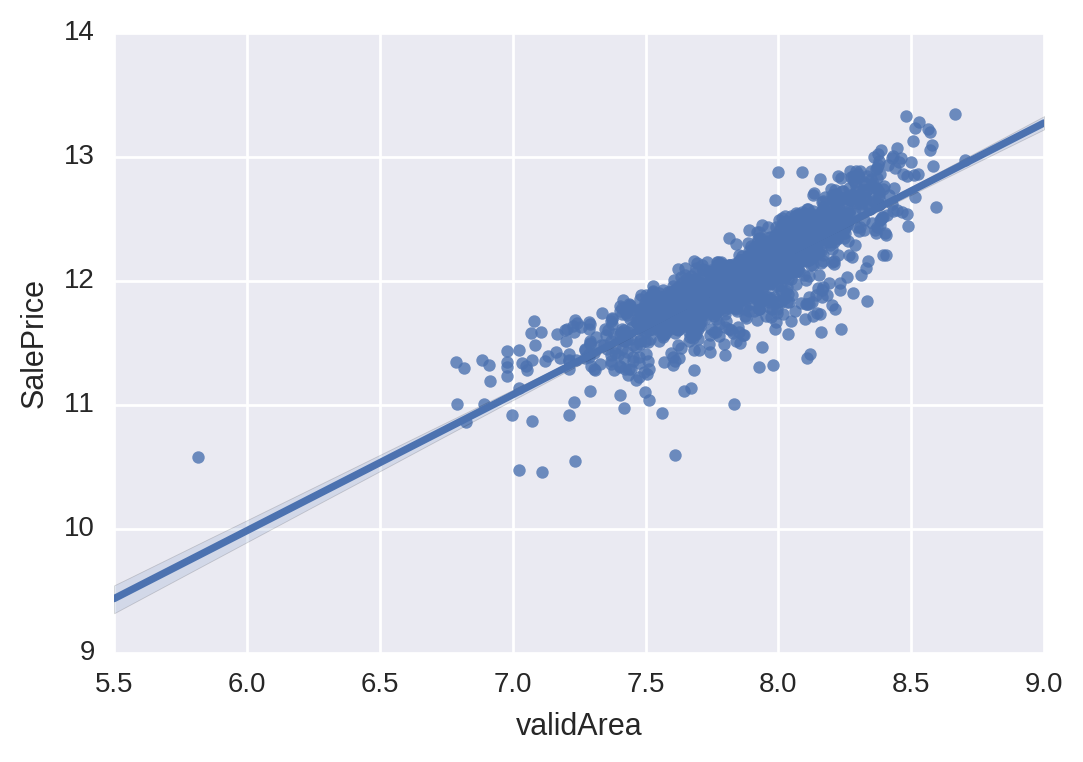

In [357]:
sns.regplot(X_train.validArea, y)